# TaskLoader tour

This notebook demonstrates how you can set up `TaskLoader` objects to load different kinds of tasks that can be used to train models that accomplish different objectives. The `TaskLoader` is very flexible and can be used to load tasks for spatial interpolation, forecasting, and downscaling, or some combination of these. The ability to use `TaskLoader`s to automatically compose ConvNP models in TensorFlow or PyTorch adds to the convenience of `deepsensor`.

In this notebook, we will demonstrate a few different tasks that can be loaded using `TaskLoader` objects. Antarctic temperature will be our target variable, using gridded ERA5 data and off-grid station data to construct tasks. However, the same principles can be applied to any other target variable and data source, as long as the data is in `xarray` or `pandas` format.

## Imports/set-up

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import logging
logging.captureWarnings(True)

In [2]:
import deepsensor.torch as deepsensor

In [3]:
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.convnp import ConvNP

In [4]:
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

In [5]:
date = "2018-01-01"

## Load data

In [6]:
# era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/processed/*/*.nc')
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc')
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [7]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*12500m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_coarse_raw_ds = aux_raw_ds.coarsen(y=2, x=2, boundary='trim').mean()

aux_raw_ds = aux_raw_ds.rename({'surface': 'elevation_12500m', 'mask': 'landmask_12500m'})
aux_coarse_raw_ds = aux_coarse_raw_ds.rename({'surface': 'elevation_25000m', 'mask': 'landmask_25000m'})

aux_raw_ds

<xarray.Dataset>
Dimensions:           (y: 559, x: 559)
Coordinates:
  * y                 (y) float64 3.488e+06 3.475e+06 ... -3.475e+06 -3.488e+06
  * x                 (x) float64 -3.488e+06 -3.475e+06 ... 3.475e+06 3.488e+06
    lat               (y, x) float32 dask.array<chunksize=(559, 559), meta=np.ndarray>
    lon               (y, x) float32 dask.array<chunksize=(559, 559), meta=np.ndarray>
Data variables:
    elevation_12500m  (y, x) float32 dask.array<chunksize=(559, 559), meta=np.ndarray>
    landmask_12500m   (y, x) float64 dask.array<chunksize=(559, 559), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [8]:
station_raw_df = pd.read_csv('../../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['time', 'y', 'x', 'station']).sort_index()[['tas']]
station_raw_df

tas
time       y             x             station                    
1948-04-01 -3.638593e+06  1.401585e+06 Macquarie_Island   5.885714
1948-04-02 -3.638593e+06  1.401585e+06 Macquarie_Island   6.675000
1948-04-03 -3.638593e+06  1.401585e+06 Macquarie_Island   4.775000
1948-04-04 -3.638593e+06  1.401585e+06 Macquarie_Island   5.150000
1948-04-05 -3.638593e+06  1.401585e+06 Macquarie_Island   4.037500
...                                                            ...
2022-06-14  1.447591e+06 -6.904655e+05 Halley_6a        -22.577778
2022-06-15  5.380525e+05 -1.606516e+06 Sky_Blu          -26.587500
            8.072843e+05 -1.351549e+06 Limbert          -23.887500
            9.270759e+05 -2.308923e+06 Rothera           -9.895833
            9.847784e+05 -1.717203e+06 Butler Island    -19.669524

[941850 rows x 1 columns]

## Normalise data

In [9]:
data_processor = DataProcessor(x1_name='y', x1_map=(0, 3.5e6), x2_name='x', x2_map=(0, 3.5e6))

In [10]:
era5_ds, station_df = data_processor([era5_raw_ds, station_raw_df])
aux_ds, aux_coarse_ds = data_processor([aux_raw_ds, aux_coarse_raw_ds], method="min_max")

In [11]:
station_df

tas
time       x1        x2        station                   
1948-04-01 -1.039598  0.400453 Macquarie_Island  1.507074
1948-04-02 -1.039598  0.400453 Macquarie_Island  1.560782
1948-04-03 -1.039598  0.400453 Macquarie_Island  1.431492
1948-04-04 -1.039598  0.400453 Macquarie_Island  1.457010
1948-04-05 -1.039598  0.400453 Macquarie_Island  1.381308
...                                                   ...
2022-06-14  0.413597 -0.197276 Halley_6a        -0.429791
2022-06-15  0.153729 -0.459005 Sky_Blu          -0.702642
            0.230653 -0.386157 Limbert          -0.518914
            0.264879 -0.659692 Rothera           0.433182
            0.281365 -0.490629 Butler Island    -0.231892

[941850 rows x 1 columns]

## Let's load some tasks!

### ERA5 spatial interpolation

A spatial interapolation model can be trained by randomly sampling grid cells from `xarray` objects, which is simple to do with `TaskLoader`.

In [12]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_coarse_ds], target=era5_ds['t2m'])
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('elevation_25000m', 'landmask_25000m'))
Target variable IDs: (('t2m',),)


In [13]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, (0.1, "all"), "all")
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [(2, 7840), ((1, 279), (1, 279))]
Y_c: [(1, 7840), (2, 279, 279)]
X_t: [((1, 280), (1, 280))]
Y_t: [(1, 280, 280)]



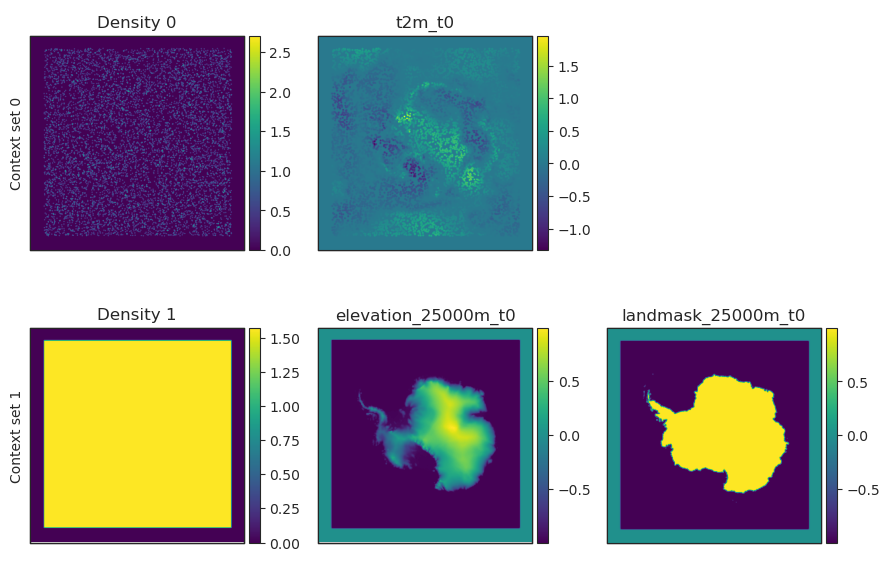

In [14]:
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

### Station spatial interpolation

Generating interpolation tasks from `pandas` station data is slightly more involved than with `xarray` gridded data. We must set up a 'link' between the station context set and the station target set when instantiating the `TaskLoader`. This is used for splitting the data into context and target sets when generating `Task`s from the `TaskLoader`.

The `TaskLoader` can also be used to sample hi-res auxiliary data at the station context and target points using the `aux_at_contexts` and `aux_at_targets` arguments. The main use case is to provide the model with high-resolution auxiliary information at in-situ, off-grid station locations. Hypothetically, with the right auxiliary information and enough data, the model can distinguish between an observation from the top of a mountain vs a valley vs a city vs a field.

In [15]:
task_loader = TaskLoader(
    context=[station_df, aux_coarse_ds],  # Two context sets: station data and coarse gridded auxiliary data
    target=station_df,  # Target set is also the station data
    links=[(0, 0)],  # Link the station context set to the station target set
    aux_at_contexts=aux_ds,  # Optional hi-res auxiliary data at the station context points, adding an extra context set
    aux_at_targets=aux_ds  # Optional hi-res auxiliary data at the station target points
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('tas',), ('elevation_25000m', 'landmask_25000m'), ('elevation_12500m', 'landmask_12500m'))
Target variable IDs: (('tas',),)
Auxiliary-at-target variable IDs: ('elevation_12500m', 'landmask_12500m')


In [16]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, ("split", "all"), "split", split_frac=0.7)
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [(2, 47), ((1, 279), (1, 279)), (2, 47)]
Y_c: [(1, 47), (2, 279, 279), (2, 47)]
X_t: [(2, 22)]
Y_t: [(1, 22)]
Y_t_aux: (2, 22)



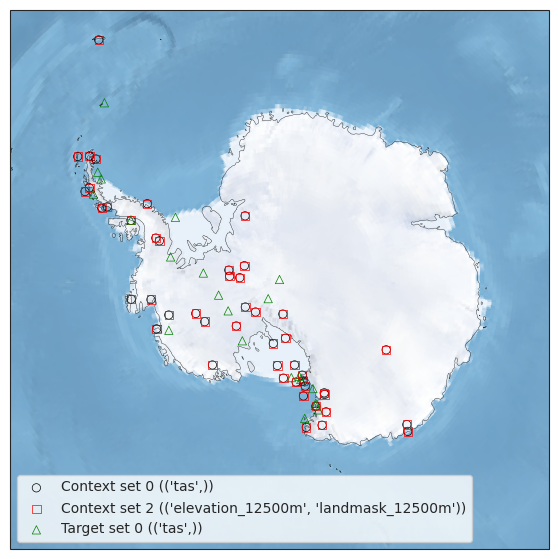

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=ccrs.LambertAzimuthalEqualArea(0, -90)))
ax.set_extent([-3.5e6, 3.5e6, -3.5e6, 3.5e6], crs=ccrs.LambertAzimuthalEqualArea(0, -90))
ax.stock_img()
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, task, data_processor, task_loader, plot_target=True, add_legend=True, linewidths=0.5)
plt.show()

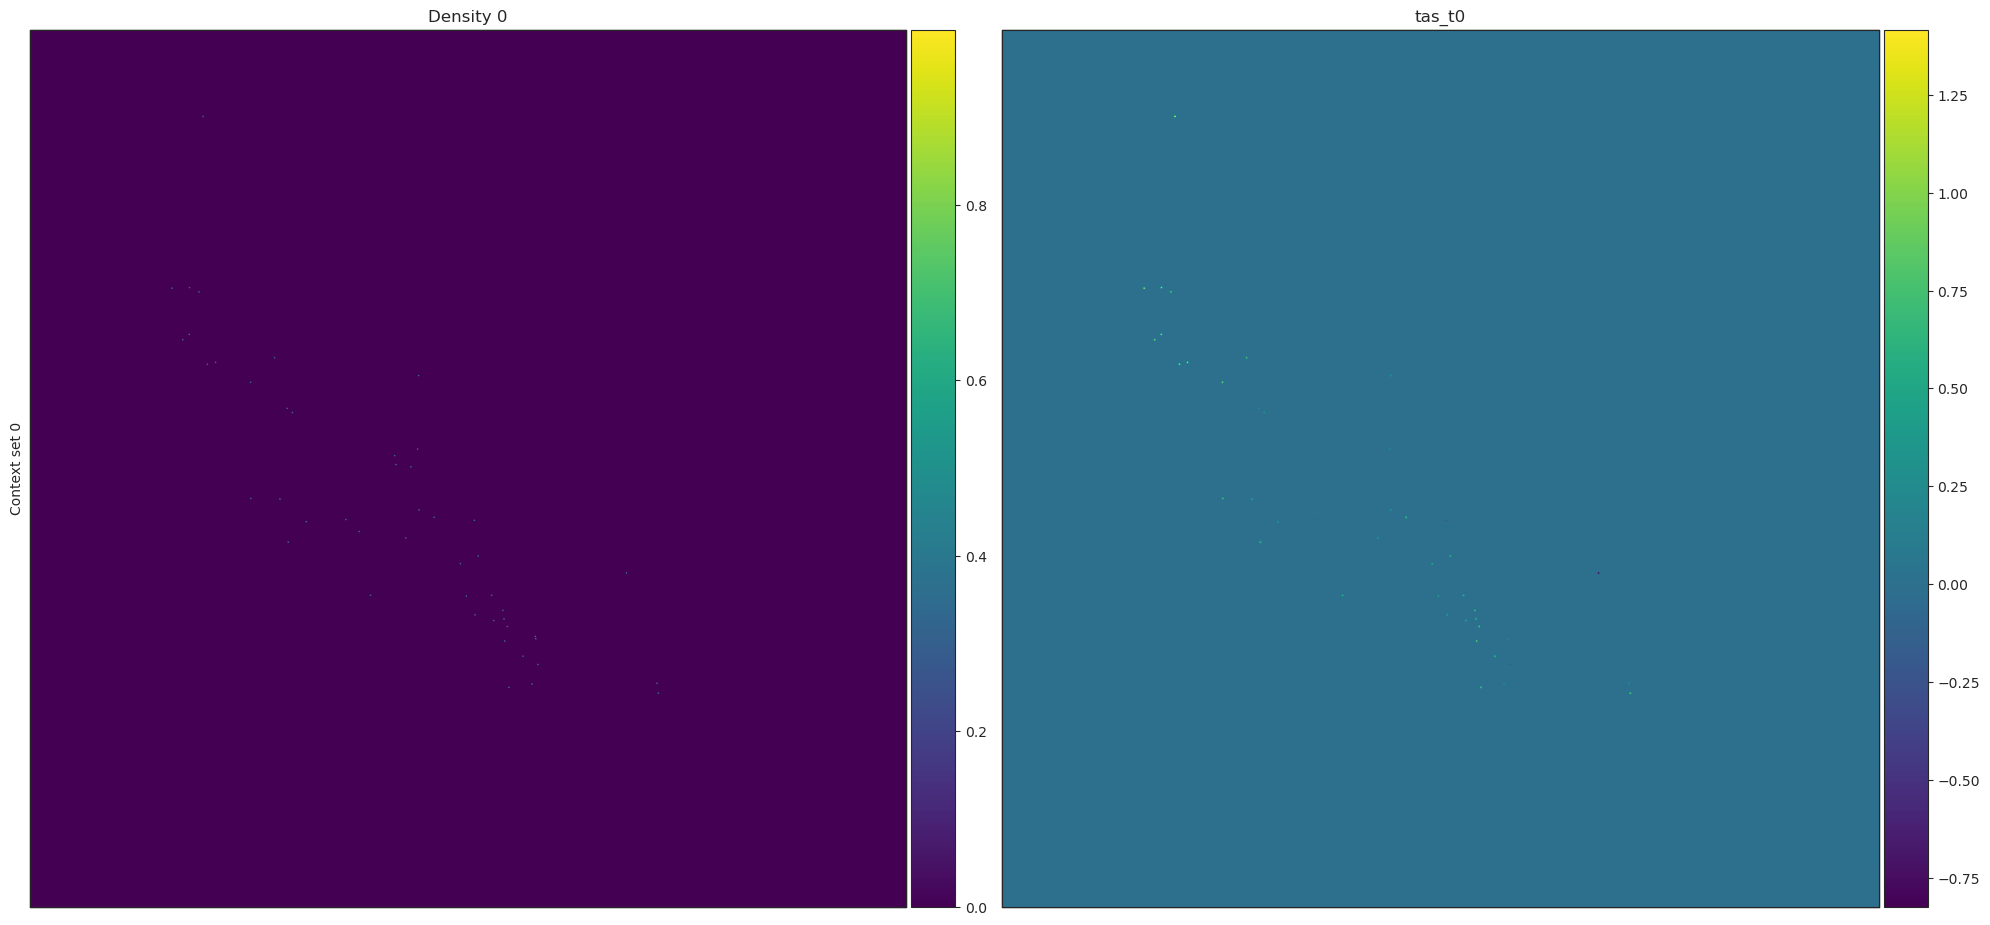

In [18]:
# Zoom-in on the station context set
fig = deepsensor.plot.context_encoding(model, task, task_loader, context_set_idxs=0, size=10, return_axes=True)
plt.show()

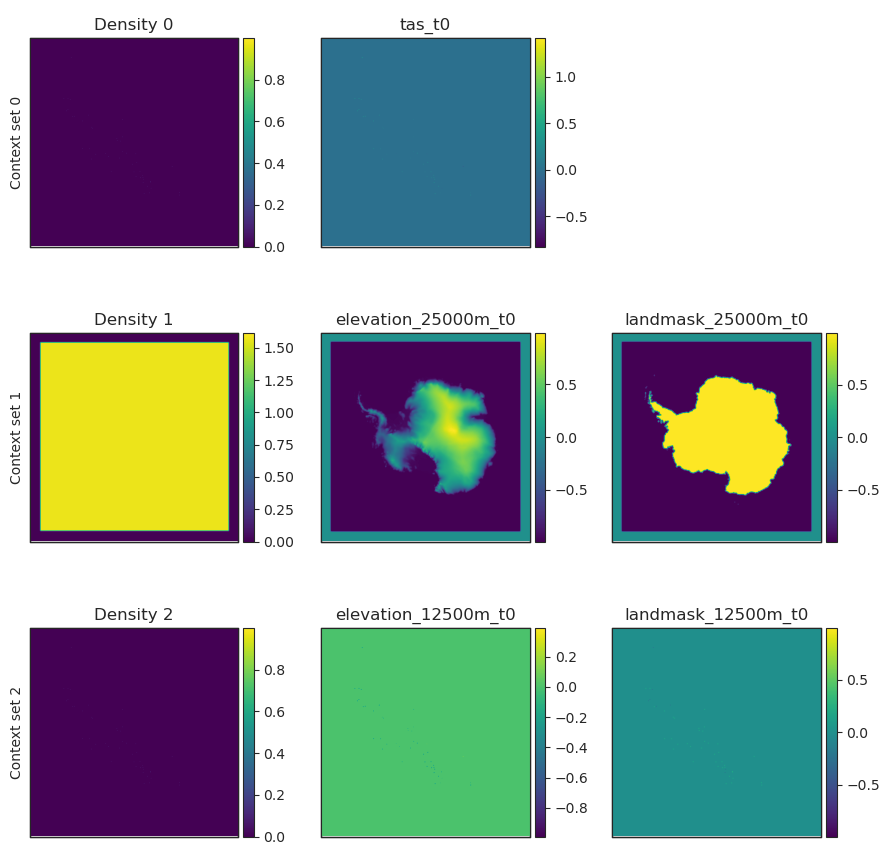

In [19]:
# Plot the whole encoding
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

### ERA5 forecasting

Using the `context_delta_t` and `target_delta_t` arguments, you can specify a time difference between the context and target.
In this case, we generate a task where the context is the current and previous time step and the target is the next time step.

By printing the `repr` of the `TaskLoader` object, we get more verbose variable IDs showing the time indexes of the context and target sets.

In [20]:
task_loader = TaskLoader(context=[era5_ds['t2m'], era5_ds['t2m'], aux_coarse_ds], target=era5_ds['t2m'],
                         context_delta_t=[-1, 0, 0], target_delta_t=1)
print(repr(task_loader))

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('t2m',), ('elevation_25000m', 'landmask_25000m'))
Target variable IDs: (('t2m',),)

Context data dimensions: (1, 1, 2)
Target data dimensions: (1,)


In [21]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, "all", "all")
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [((1, 280), (1, 280)), ((1, 280), (1, 280)), ((1, 279), (1, 279))]
Y_c: [(1, 280, 280), (1, 280, 280), (2, 279, 279)]
X_t: [((1, 280), (1, 280))]
Y_t: [(1, 280, 280)]



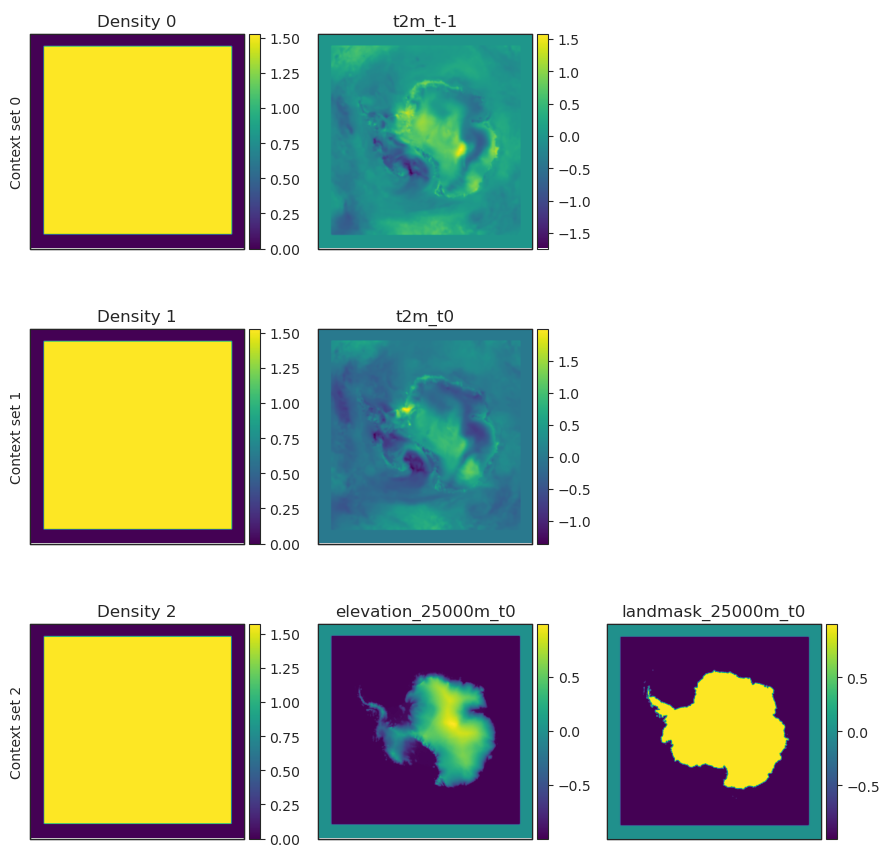

In [22]:
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

### ERA5 downscaling using station targets

We will pass the station data as the target set. This set-up can be used to train a model to downscale coarse gridded data to station observations. Finally, we will pass hi-res auxiliary information (e.g. local topgraphic information) at the target points (see the `Y_t_aux` key in the `Task`). When this `TaskLoader` is used to instantiate a `ConvNP`, this hi-res data will be injected into the model via an output MLP.

In [23]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_coarse_ds], target=station_df, aux_at_targets=aux_ds)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('elevation_25000m', 'landmask_25000m'))
Target variable IDs: (('tas',),)
Auxiliary-at-target variable IDs: ('elevation_12500m', 'landmask_12500m')


In [24]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, "all", "all")
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [((1, 280), (1, 280)), ((1, 279), (1, 279))]
Y_c: [(1, 280, 280), (2, 279, 279)]
X_t: [(2, 69)]
Y_t: [(1, 69)]
Y_t_aux: (2, 69)



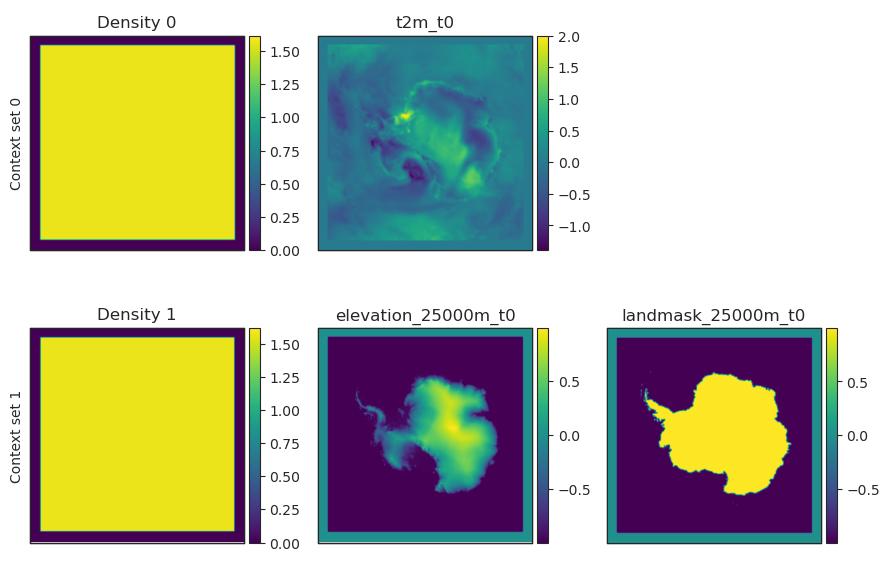

In [25]:
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

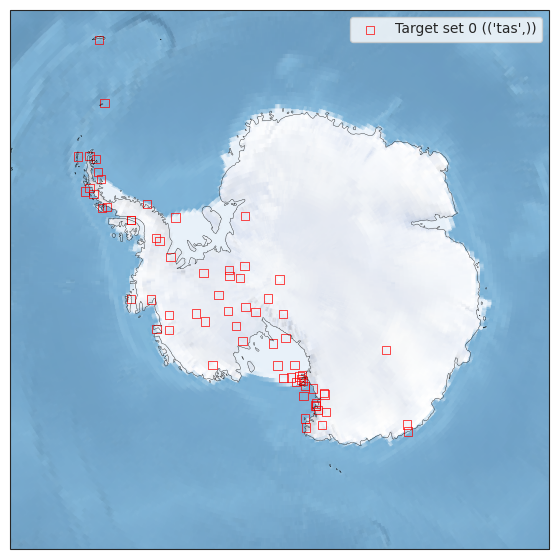

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=ccrs.LambertAzimuthalEqualArea(0, -90)))
ax.set_extent([-3.5e6, 3.5e6, -3.5e6, 3.5e6], crs=ccrs.LambertAzimuthalEqualArea(0, -90))
ax.stock_img()
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, task, data_processor, task_loader, plot_target=True, add_legend=True, linewidths=0.5)
plt.show()

### TODO: Satellite data interpolation

## What's missing?

Is some functionality missing that you would like to see? Please open an issue on the [GitHub repository](https://github.com/tom-andersson/deepsensor/tree/main).

